## 0. Introduction

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network.

1.   This lab is the third course-work activity **Assignment 1 Part 3: Neural Networks**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
8. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
9. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="red">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

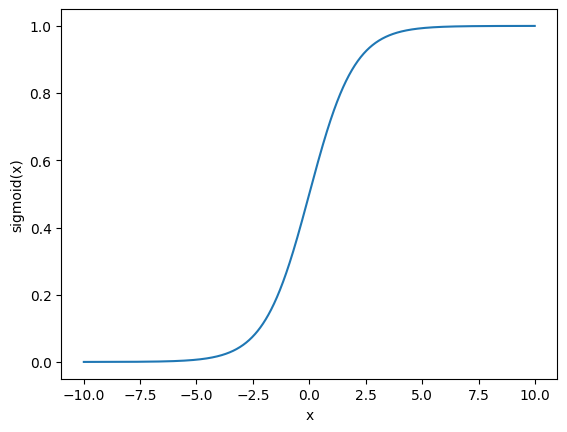

In [2]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
  z = 1/(1 + torch.exp(-z))
  return z


x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [3]:
import torch.nn as nn

class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, num_features), requires_grad=True)

  def forward(self, x):
    y = sigmoid(x @ self.weight.T)
    return y

# 1. The XOR problem

Let's revisit the XOR problem.

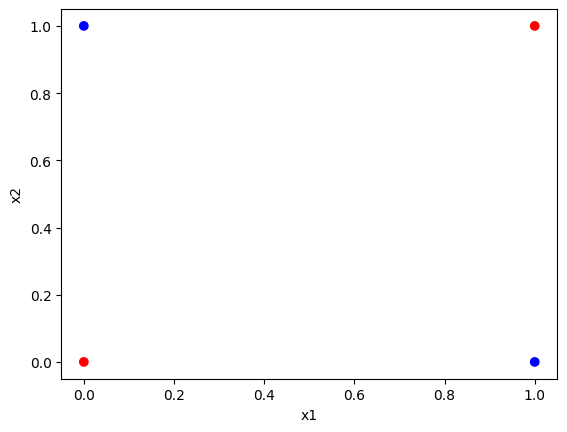

In [4]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Q2. How does a NN solve the XOR problem? [1 marks]Q2. How does a NN solve the XOR problem? [1 marks]

We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

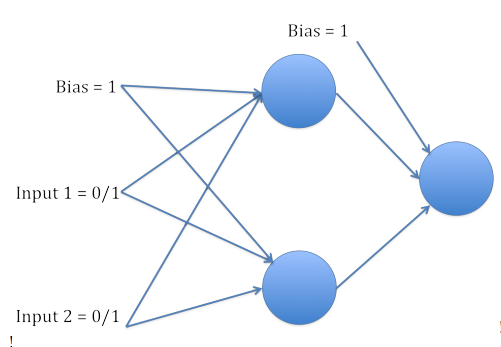

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_neurons, num_outputs):
        super().__init__()
        self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
        self.output_layer = nn.ModuleList([LogisticRegression(num_neurons + 1) for i in range(num_outputs)])  # +1 for the bias

    def forward(self, x: torch.tensor) -> torch.tensor:
        y_hidden = torch.ones(len(self.hidden_layer) + 1)  # +1 for the bias
        for i, neuron in enumerate(self.hidden_layer):
            y_hidden[i] = neuron(x)

        # Pass the hidden layer output to the output layer neuron(s)
        y_output = torch.ones(len(self.output_layer))  # No need for bias here as it’s the final layer
        for i, neuron in enumerate(self.output_layer):
            y_output[i] = neuron(y_hidden)

        return y_output[0]  # Assuming a single output neuron

    def backward_pass(self, x: torch.tensor, target: torch.tensor, learning_rate: float):
      # we are getting delta_k for output layer neoron as per step 1
      y_hidden = torch.ones(len(self.hidden_layer) + 1)  # Forward pass to get hidden neuron outputs
      for i, neuron in enumerate(self.hidden_layer):
          y_hidden[i] = neuron(x)

      y_output = torch.ones(len(self.output_layer))
      for i, neuron in enumerate(self.output_layer):
          y_output[i] = neuron(y_hidden)

      output_deltas = torch.zeros(len(self.output_layer))
      for k, y_k in enumerate(y_output):
          t_k = target[k]
          g_prime = y_k * (1 - y_k)  # Derivative of sigmoid
          output_deltas[k] = (y_k - t_k) * g_prime

      # Step 2: Compute delta_j for hidden layer neurons
      hidden_deltas = torch.zeros(len(self.hidden_layer))
      for j, neuron in enumerate(self.hidden_layer):
          x_j = y_hidden[j]  # Value after activation
          g_prime_j = x_j * (1 - x_j)  # Derivative of sigmoid
          weighted_sum = 0.0
          for k, delta_k in enumerate(output_deltas):
              weighted_sum += self.output_layer[k].weight[0, j] * delta_k
          hidden_deltas[j] = g_prime_j * weighted_sum

      #updating weight for output layer as per step 3
      with torch.no_grad():
          for k, neuron in enumerate(self.output_layer):
              for j in range(len(y_hidden)):
                  neuron.weight[0, j] -= learning_rate * output_deltas[k] * y_hidden[j]

      #finally as per step 4 we are updating the hidden layer weights
      with torch.no_grad():
          for j, neuron in enumerate(self.hidden_layer):
              for i in range(len(x)):
                  neuron.weight[0, i] -= learning_rate * hidden_deltas[j] * x[i]

# Test the backward_pass method
x_test = torch.tensor([0., 0., 1.])  # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
model.backward_pass(x_test, y_test, learning_rate=0.1)

In [6]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor(0.5733, grad_fn=<SelectBackward0>)
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[-0.4033, -0.5966,  0.1820]], requires_grad=True)
hidden_layer.1.weight Parameter containing:
tensor([[-0.8567,  1.1006, -1.0712]], requires_grad=True)
output_layer.0.weight Parameter containing:
tensor([[ 0.1227, -0.5663,  0.3731]], requires_grad=True)

Hidden layer weight matrix:
tensor([[[-0.4033, -0.5966,  0.1820]],

        [[-0.8567,  1.1006, -1.0712]]], grad_fn=<StackBackward0>)


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to propagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [7]:
# test it works
model.backward_pass(x_test, y_test, 1)

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

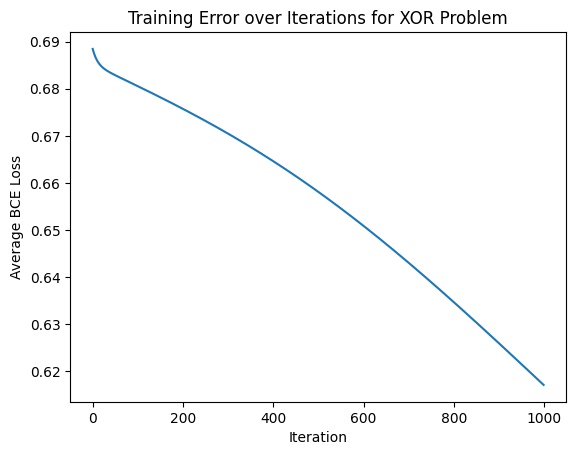

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 1. 1. 1.]


In [8]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  N = y_true.shape[0]
  return (-1/N)*torch.sum(((1-y_true) * torch.log(1-y_pred))+(y_true * torch.log(y_pred)))
# tensors are the xor inputs
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.1 and 100 as our learning rate and number of iterations
lr = 0.1
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())


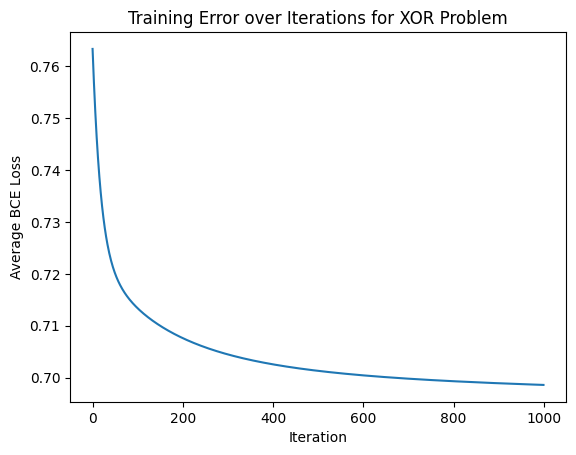

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 1. 0. 0.]


In [9]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.01 and 1000 as our learning rate and number of iterations
lr = 0.1
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

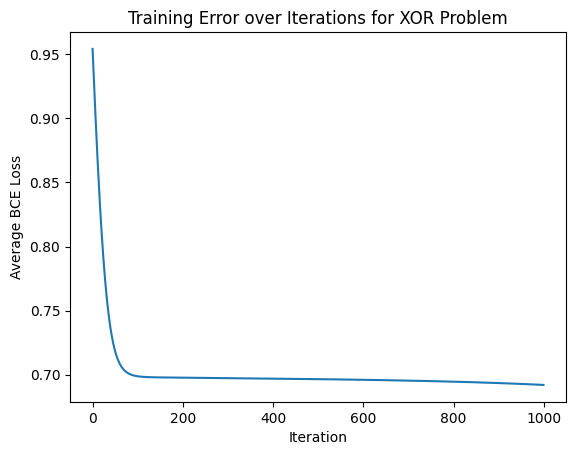

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 1. 1. 1.]


In [10]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.1 and 100 as our learning rate and number of iterations
lr = 0.1
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

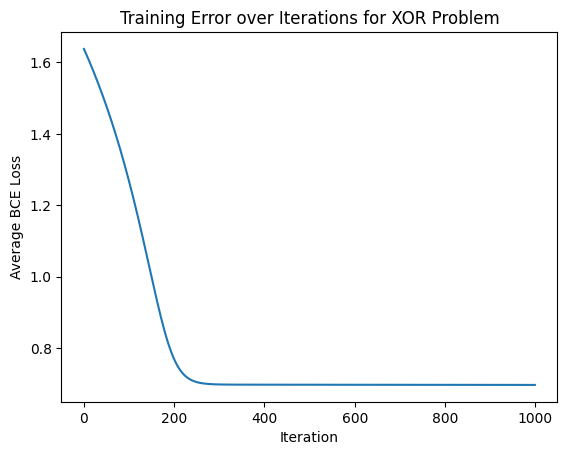

True outputs: [0. 1. 1. 0.]
Predicted outputs: [1. 0. 1. 0.]


In [11]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.05 and 100 as our learning rate and number of iterations
lr = 0.05
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

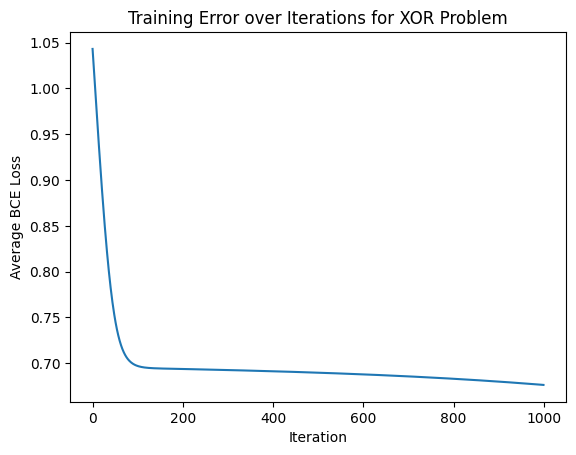

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 0. 1. 0.]


In [12]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.1 and 100 as our learning rate and number of iterations
lr = 0.09
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

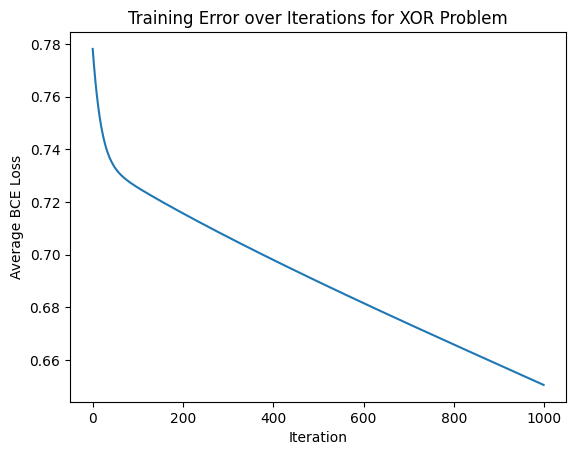

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 1. 1. 1.]


In [13]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.1 and 100 as our learning rate and number of iterations
lr = 0.07
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

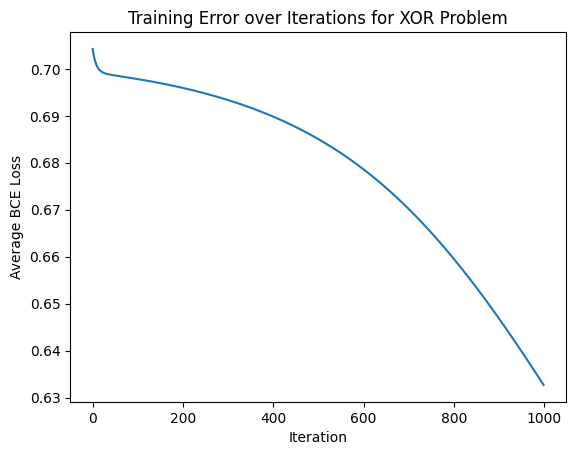

True outputs: [0. 1. 1. 0.]
Predicted outputs: [0. 0. 1. 0.]


In [14]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR

# chose 0.1 and 100 as our learning rate and number of iterations
lr = 0.15
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

In [15]:
#threshold seems to be lr of 0.08

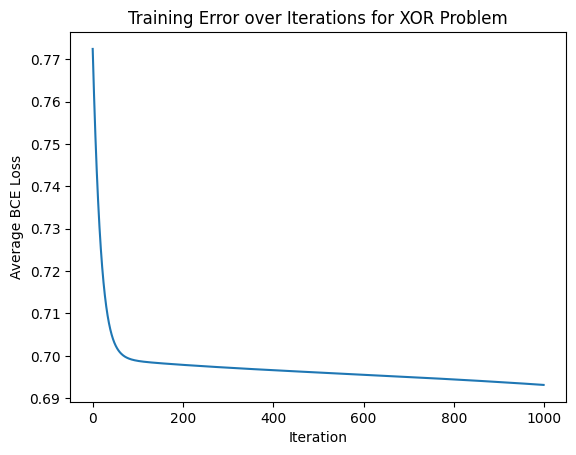

True outputs: [0. 1. 1. 0.]
Predicted outputs: [1. 1. 0. 0.]


In [16]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)  # Shape: (4, 3)
y = torch.tensor([0., 1., 1., 0.])  # Target outputs for XOR


lr = 0.085
iterations = 1000

model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1) #instance of our model


errors = [] #error tracking list

for ep in range(iterations):
    error = 0
    for i in range(x.shape[0]):

        y_pred = model(x[i])


        error += bce(y[i].unsqueeze(0), y_pred)


        model.backward_pass(x[i], y[i].unsqueeze(0), lr) #back


    errors.append(error.item() / x.shape[0]) #this is average for error in each iteration/epoch

# Plot the error over iterations to visualize training progress
plt.plot(range(iterations), errors)
plt.xlabel("Iteration")
plt.ylabel("Average BCE Loss")
plt.title("Training Error over Iterations for XOR Problem")
plt.show()

# Test the trained model on the XOR inputs
y_pred = torch.zeros_like(y)
for i in range(x.shape[0]):
    y_pred[i] = model(x[i]).round()  # Round predictions to get binary output

print("True outputs:", y.numpy())
print("Predicted outputs:", y_pred.detach().numpy())

# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [17]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [18]:
# LIKE WEEK 4 we split the data with a fixed random seed and convert to tensors
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=42
)

x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

# Normalising based on week 4 function
def norm_set(x, mu, sigma):
    return (x - mu) / sigma

mean = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = norm_set(x_train, mean, std)
x_test = norm_set(x_test, mean, std)

Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.

<u><font color="red"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>


Training MLP with 1 hidden neurons


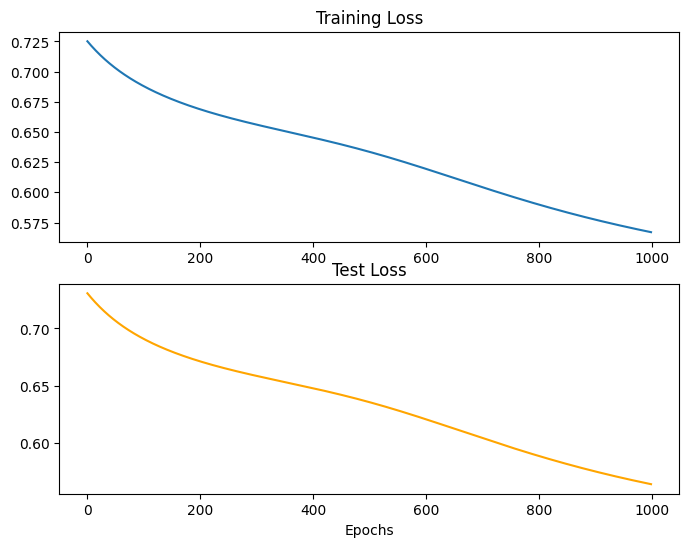

Minimum train cost: 0.5669960975646973
Minimum test cost: 0.5643239617347717

Training MLP with 2 hidden neurons


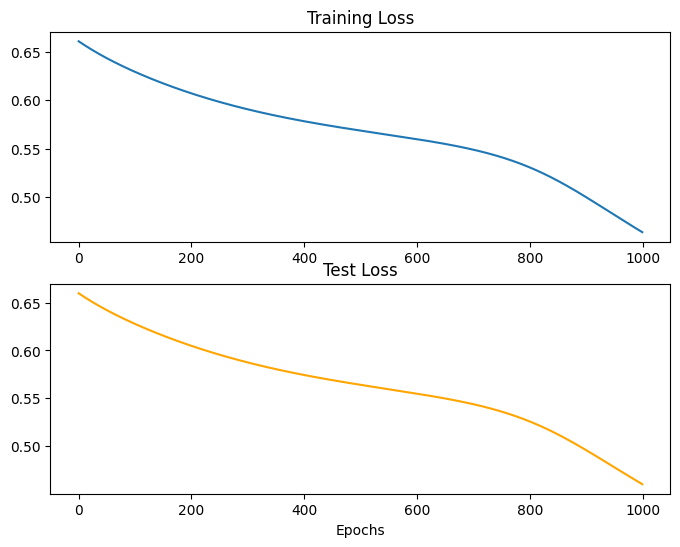

Minimum train cost: 0.46385976672172546
Minimum test cost: 0.46015340089797974

Training MLP with 4 hidden neurons


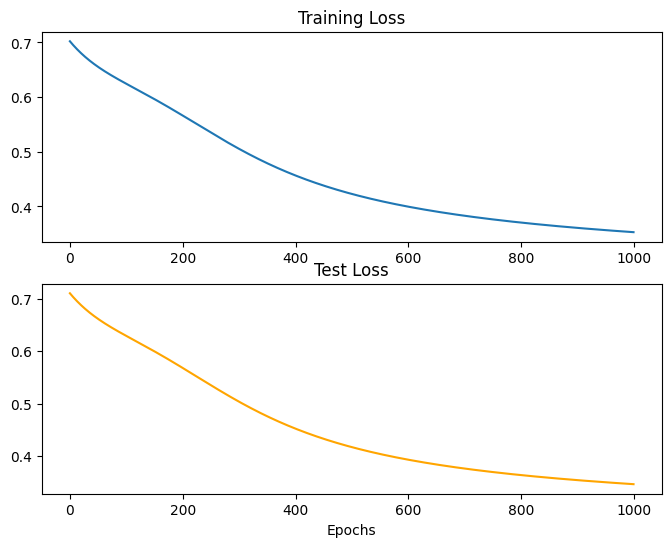

Minimum train cost: 0.35301345586776733
Minimum test cost: 0.3463994562625885

Training MLP with 8 hidden neurons


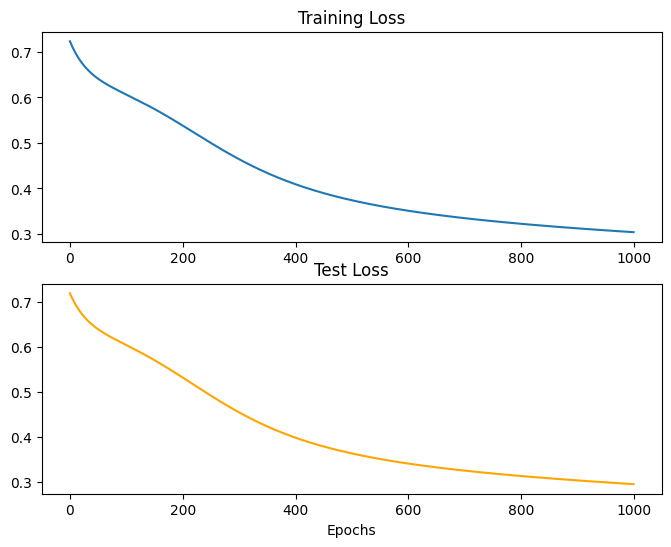

Minimum train cost: 0.30400705337524414
Minimum test cost: 0.2940673828125

Training MLP with 16 hidden neurons


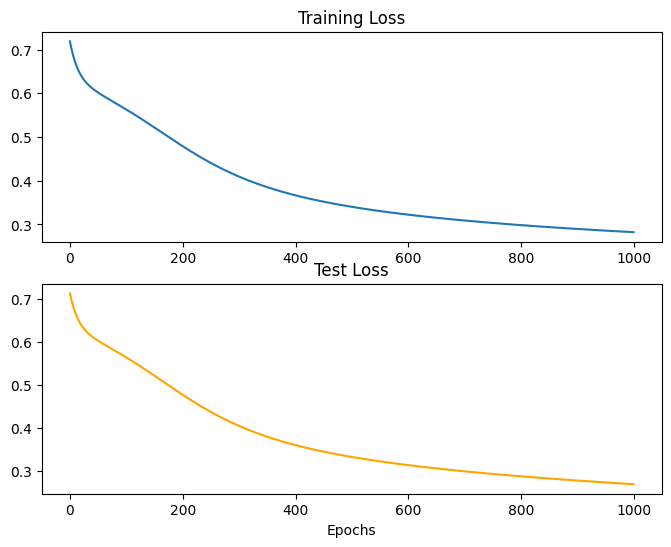

Minimum train cost: 0.2822045087814331
Minimum test cost: 0.2688370645046234

Training MLP with 32 hidden neurons


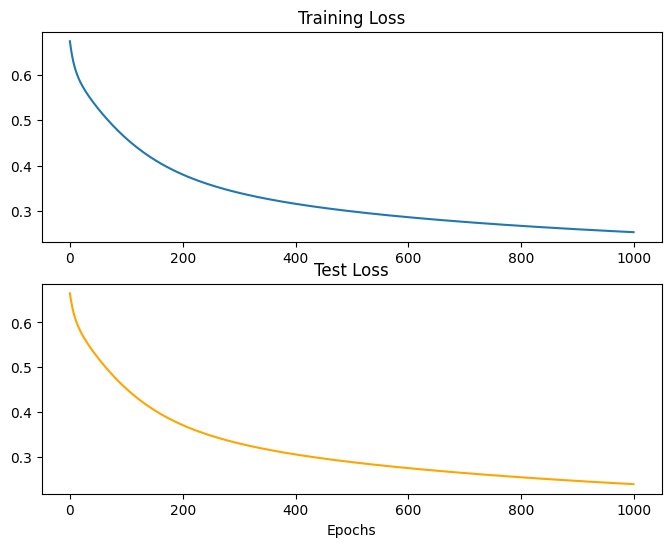

Minimum train cost: 0.2526884377002716
Minimum test cost: 0.23866918683052063


In [19]:




class NeuralNetwork(nn.Module):
    def __init__(self, num_neurons):
        super().__init__()

        self.hidden_layer = nn.Linear(4, num_neurons, bias=False) # 4 is for the features in the iris data

        self.output_layer = nn.Linear(num_neurons, 3, bias=False) #output layer 3 neurons for (setosa, versicolor, and virginica).
        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # forward function applys hidden then output
        x = self.sigmoid(self.hidden_layer(x))
        outputs = self.sigmoid(self.output_layer(x))
        return outputs

# Training loop based on our week 4 one
def train(model, x_train, y_train, x_test, y_test, optimizer, epochs=1000):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train)
        loss = F.binary_cross_entropy(predictions, F.one_hot(y_train, num_classes=3).float(), reduction='mean')
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

        # Testing phase
        model.eval()
        with torch.no_grad():
            test_predictions = model(x_test)
            test_loss = F.binary_cross_entropy(test_predictions, F.one_hot(y_test, num_classes=3).float(), reduction='mean')
            test_losses.append(test_loss.item())

    # Plot the training and test loss
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    axs[0].plot(range(epochs), train_losses, label="Training Loss")
    axs[1].plot(range(epochs), test_losses, label="Test Loss", color='orange')
    axs[0].set_title("Training Loss")
    axs[1].set_title("Test Loss")
    plt.xlabel("Epochs")
    plt.show()

    print(f"Minimum train cost: {min(train_losses)}")
    print(f"Minimum test cost: {min(test_losses)}")

# from the list in the question we now then train our network with different numbers-hidden neurons
hidden_neurons_list = [1, 2, 4, 8, 16, 32]
learning_rate = 0.1
epochs = 1000

for num_neurons in hidden_neurons_list:
    print(f"\nTraining MLP with {num_neurons} hidden neurons")
    model = NeuralNetwork(num_neurons=num_neurons)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train(model, x_train, y_train, x_test, y_test, optimizer, epochs=epochs)

